# Step 1: Prepare Genre-Specific Datasets
Filter the Dataset by Genre: Create separate datasets for each genre.

In [21]:
import pandas as pd

# Load the dataset
data = pd.read_csv('datasets/cleaned_lyrics_dataset.csv')

# Create separate datasets for each genre
genres = data['Genre'].unique()
for genre in genres:
    genre_data = data[data['Genre'] == genre]['Lyrics']
    file_name = f"{genre}_lyrics.txt"
    genre_data.dropna().to_csv(file_name, index=False, header=False)
    print(f"Saved {file_name} with {len(genre_data)} songs.")


Saved Jazz_lyrics.txt with 572 songs.
Saved Electronic_lyrics.txt with 1088 songs.
Saved Country_lyrics.txt with 978 songs.
Saved Hip-Hop_lyrics.txt with 808 songs.
Saved Rock_lyrics.txt with 734 songs.
Saved Pop_lyrics.txt with 1290 songs.


# Step 2: Tokenize Genre-Specific Data
Tokenize each genre's dataset using the Hugging Face tokenizer.

In [24]:
from transformers import GPT2Tokenizer
from datasets import load_dataset

# Load the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Add a padding token
tokenizer.pad_token = tokenizer.eos_token

# Replace invalid characters in genre names
cleaned_genres = [genre.replace("-", "_") for genre in genres]

# Function to tokenize text
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

# Process each genre's dataset with cleaned names
tokenized_datasets = {}
for genre, cleaned_genre in zip(genres, cleaned_genres):
    dataset = load_dataset("text", data_files={f"{cleaned_genre}": f"{genre}_lyrics.txt"})
    tokenized_datasets[cleaned_genre] = dataset.map(tokenize_function, batched=True)


Generating Hip_Hop split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/57296 [00:00<?, ? examples/s]

Generating Rock split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/36454 [00:00<?, ? examples/s]

Generating Pop split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/67654 [00:00<?, ? examples/s]

In [12]:
pip install transformers datasets torch

Note: you may need to restart the kernel to use updated packages.


# Fine tuning

In [25]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
from datasets import load_dataset
import torch

# Define genres
genres = ["Jazz", "Pop", "Rock", "Country", "Electronic", "Hip-Hop"]  # Add your genres here
cleaned_genres = [genre.lower().replace("-", "_") for genre in genres]

# Load GPT-2 tokenizer and add padding token
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set padding token

# Tokenization function
def tokenize_function(examples):
    # Tokenize the input text and add labels for loss computation
    tokens = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)
    tokens["labels"] = tokens["input_ids"].copy()  # Labels for loss computation
    return tokens

# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Loop through each genre
for genre, cleaned_genre in zip(genres, cleaned_genres):
    print(f"Processing genre: {genre}")

    # Load the dataset
    dataset = load_dataset("text", data_files={cleaned_genre: f"{genre}_lyrics.txt"})
    
    # Tokenize the dataset
    tokenized_dataset = dataset[cleaned_genre].map(tokenize_function, batched=True)
    
    # Split dataset into train and validation sets
    split_datasets = tokenized_dataset.train_test_split(test_size=0.1)
    train_dataset = split_datasets["train"]
    eval_dataset = split_datasets["test"]

    # Load pre-trained GPT-2 model
    model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f"./results_{genre}",
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        weight_decay=0.01,
        num_train_epochs=3,
        per_device_train_batch_size=4,
        save_steps=1000,
        save_total_limit=2,
        logging_dir=f"./logs_{genre}",
        logging_steps=100,
        fp16=False,  # Disable fp16 since it's incompatible with MPS
        bf16=torch.backends.mps.is_available(),  # Enable bf16 for MPS if available
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
    )

    # Train the model
    print(f"Training model for genre: {genre}")
    trainer.train()

    # Save the fine-tuned model
    model.save_pretrained(f"./fine_tuned_gpt2_{genre}")
    tokenizer.save_pretrained(f"./fine_tuned_gpt2_{genre}")
    print(f"Saved fine-tuned model for {genre} at ./fine_tuned_gpt2_{genre}")


Using device: mps
Processing genre: Jazz


Generating jazz split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/88705 [00:00<?, ? examples/s]

/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/04/byk4nbts3g94l_n39hc97_tm0000gp/T/ipykernel_63045/563004256.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training model for genre: Jazz


Epoch,Training Loss,Validation Loss
1,0.092600,0.084529
2,0.091200,0.081112
3,0.075400,0.080174


Saved fine-tuned model for Jazz at ./fine_tuned_gpt2_Jazz
Processing genre: Pop


Generating pop split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/67654 [00:00<?, ? examples/s]

/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/04/byk4nbts3g94l_n39hc97_tm0000gp/T/ipykernel_63045/563004256.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training model for genre: Pop


Epoch,Training Loss,Validation Loss
1,0.048600,0.051502
2,0.056400,0.049297
3,0.048800,0.048777


Saved fine-tuned model for Pop at ./fine_tuned_gpt2_Pop
Processing genre: Rock


Generating rock split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/36454 [00:00<?, ? examples/s]

/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/04/byk4nbts3g94l_n39hc97_tm0000gp/T/ipykernel_63045/563004256.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training model for genre: Rock


Epoch,Training Loss,Validation Loss
1,0.048700,0.050175
2,0.055700,0.047925
3,0.057300,0.047538


Saved fine-tuned model for Rock at ./fine_tuned_gpt2_Rock
Processing genre: Country


Generating country split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/35065 [00:00<?, ? examples/s]

/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/04/byk4nbts3g94l_n39hc97_tm0000gp/T/ipykernel_63045/563004256.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training model for genre: Country


Epoch,Training Loss,Validation Loss
1,0.057100,0.058038
2,0.056600,0.056148
3,0.053300,0.055758


Saved fine-tuned model for Country at ./fine_tuned_gpt2_Country
Processing genre: Electronic


Generating electronic split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/83708 [00:00<?, ? examples/s]

/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/04/byk4nbts3g94l_n39hc97_tm0000gp/T/ipykernel_63045/563004256.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training model for genre: Electronic


Epoch,Training Loss,Validation Loss
1,0.063900,0.060291
2,0.064800,0.057198
3,0.059200,0.056319


Saved fine-tuned model for Electronic at ./fine_tuned_gpt2_Electronic
Processing genre: Hip-Hop


Generating hip_hop split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/57296 [00:00<?, ? examples/s]

/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/04/byk4nbts3g94l_n39hc97_tm0000gp/T/ipykernel_63045/563004256.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training model for genre: Hip-Hop


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

# Generate lyrics

In [30]:
from transformers import pipeline
import torch

def generate_lyrics(genre, prompt, max_length=200, min_length=50, num_return_sequences=1):
    try:
        model_path = f"./fine_tuned_gpt2_{genre}"
        generator = pipeline(
            "text-generation",
            model=model_path,
            tokenizer=tokenizer,
            device=0 if torch.cuda.is_available() else -1
        )
        generated = generator(
            prompt,
            max_length=max_length,
            min_length=min_length,
            num_return_sequences=num_return_sequences,
            truncation=True,
            temperature=1.2,
            top_k=50,
            top_p=0.95
        )
        print(f"Generated lyrics for {genre}:\n{generated[0]['generated_text']}")
    except Exception as e:
        print(f"Error generating lyrics for {genre}: {e}")


# Test lyric generation
prompts = {
    "Jazz": "love, night, melody",
    "Pop": "dream, bright, stars",
    "Rock": "freedom, fire, soul",
    "Country": "heart, home, river",
    "Electronic": "beats, rhythm, energy"
}

for genre, prompt in prompts.items():
    print(f"\n--- Generating lyrics for {genre} ---")
    generate_lyrics(genre, prompt)



--- Generating lyrics for Jazz ---
Generated lyrics for Jazz:
love, night, melody, and song, and feel the peace in the earth, feel the warmth in your soul mate, love that's there too, love that makes me sick in my head, love you, give me heart too, and keep the hope in the night, don't forget to wake the next night.

--- Generating lyrics for Pop ---
Generated lyrics for Pop:
dream, bright, stars fly over town" (Ah, ayy) [ __ ]"This could be about you or me,"" she said, like someone else she knew with some common sense, like some pretty bad people or bad people just like that. 

--- Generating lyrics for Rock ---
Generated lyrics for Rock:
freedom, fire, soul, I've got a plan for ya" – Jon Hamm. ""Soften Me"" (2018) to be published by Bloq Music, Inc.." (2018)  "Wrap Up"" is another EP of Jon Hamm.

--- Generating lyrics for Country ---
Generated lyrics for Country:
heart, home, river, river, shepherds, shepherds, theyh boys, you can do this for me, just lay your life and let it go ho

# Visualizing word frequencies in generated lyrics

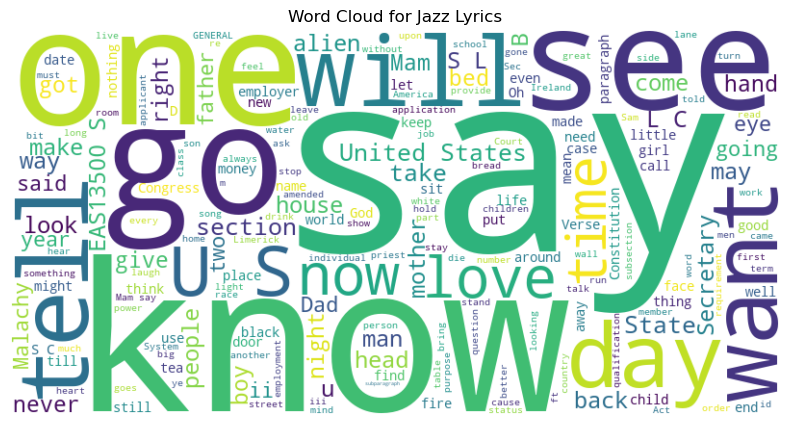

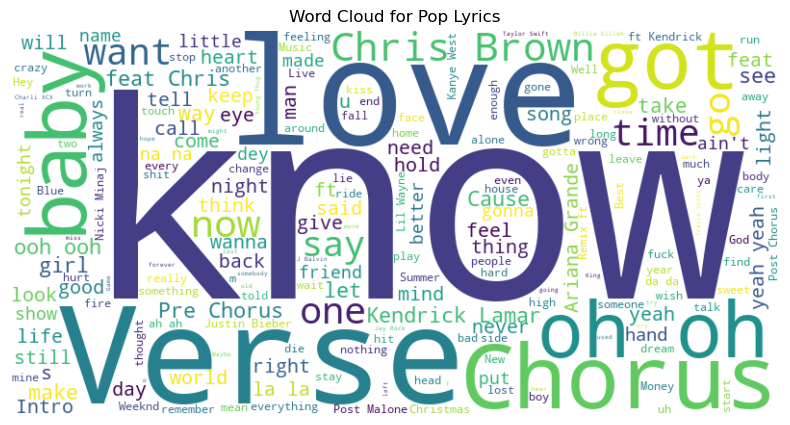

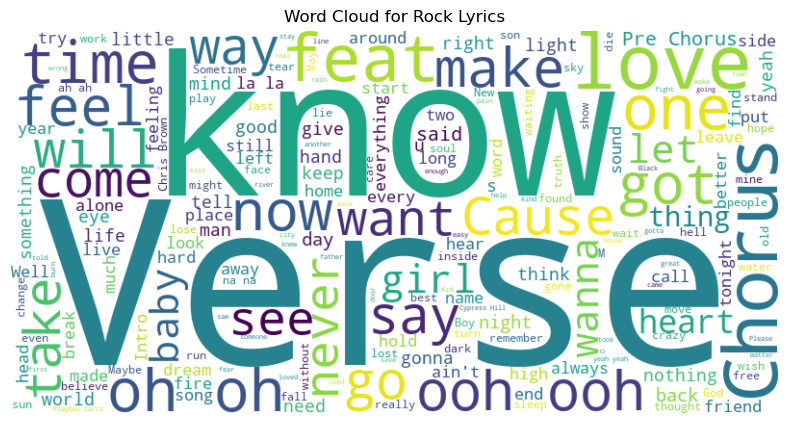

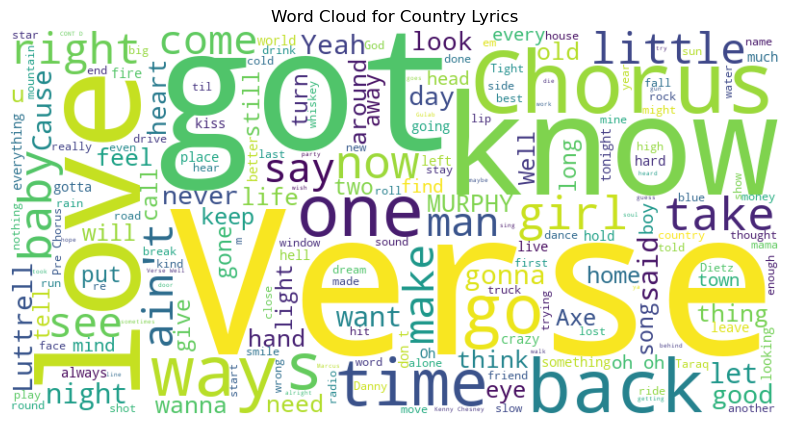

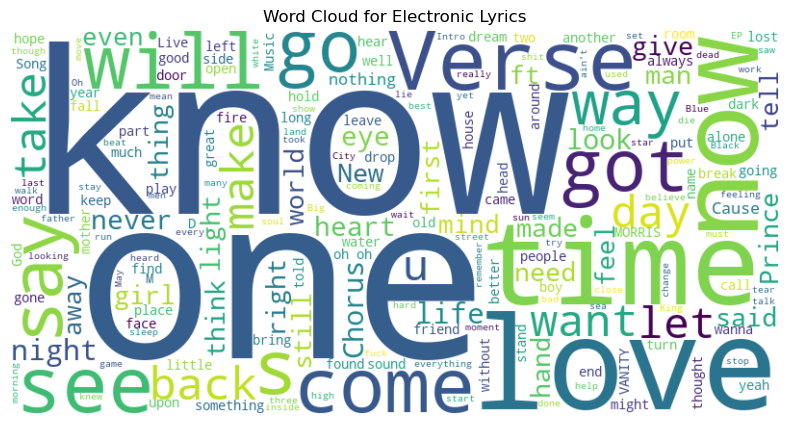

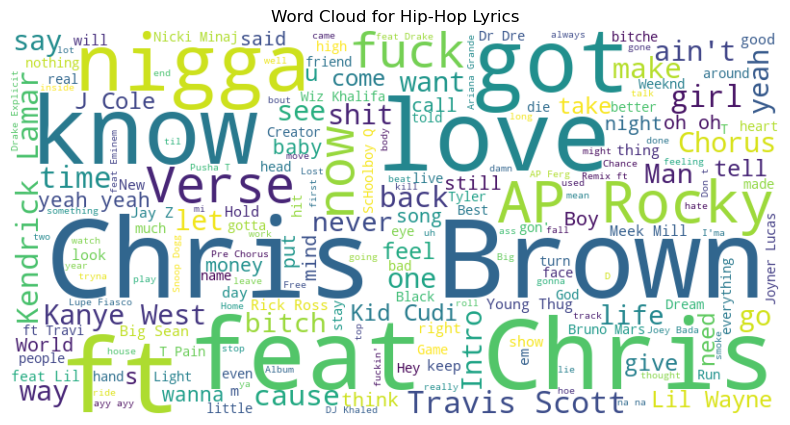

In [31]:
# Example: Visualizing word frequencies in generated lyrics
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate a word cloud for each genre's lyrics
for genre in genres:
    try:
        with open(f"{genre}_lyrics.txt", "r") as file:
            text = file.read()
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for {genre} Lyrics")
        plt.show()
    except Exception as e:
        print(f"Error creating word cloud for {genre}: {e}")


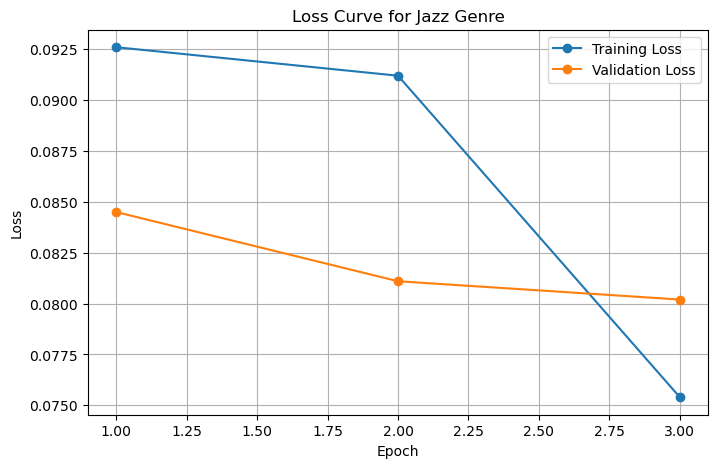

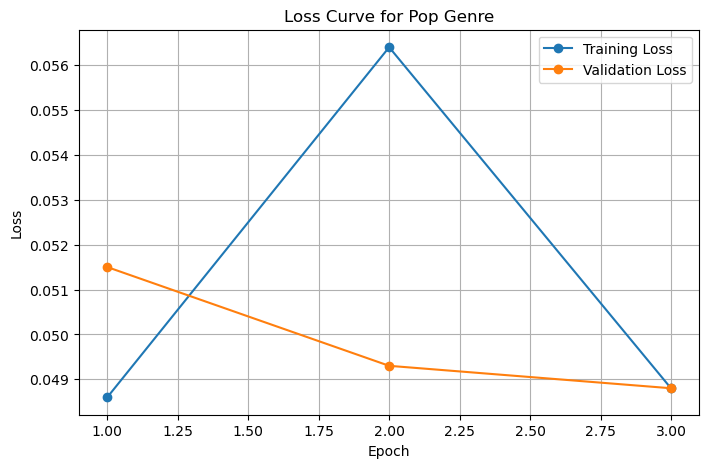

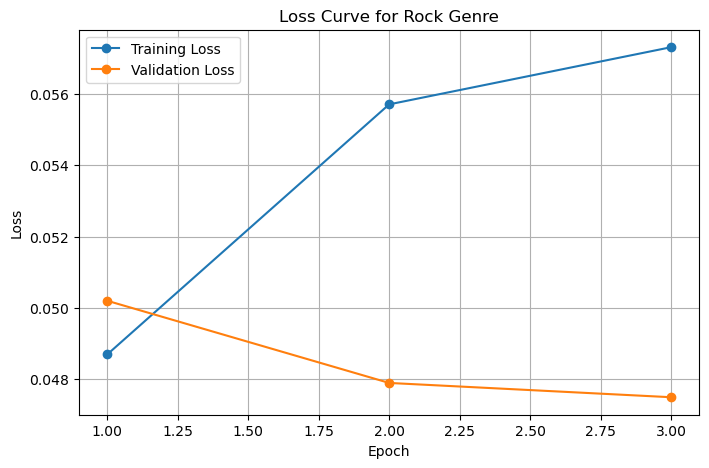

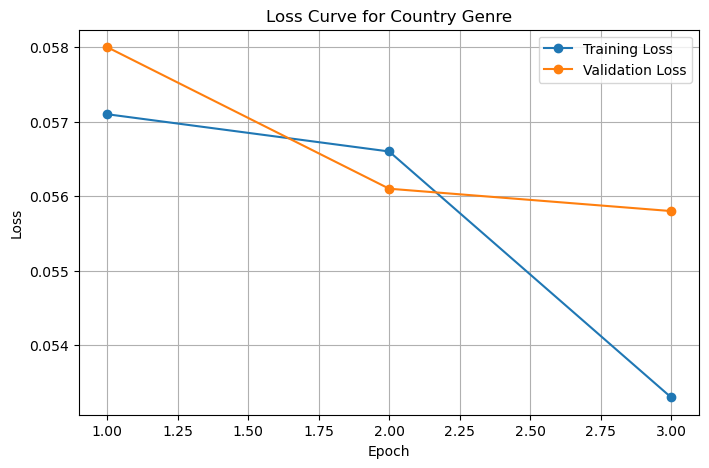

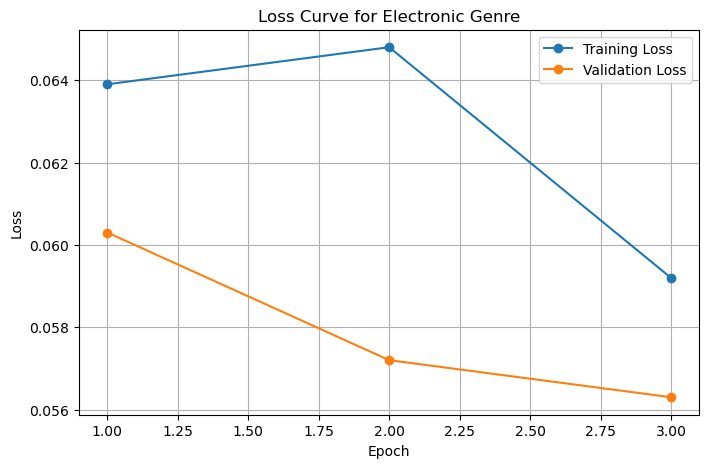

In [33]:
import matplotlib.pyplot as plt

# Jazz data
training_loss_jazz = [0.0926, 0.0912, 0.0754]
validation_loss_jazz = [0.0845, 0.0811, 0.0802]

# Pop data
training_loss_pop = [0.0486, 0.0564, 0.0488]
validation_loss_pop = [0.0515, 0.0493, 0.0488]

# Rock data
training_loss_rock = [0.0487, 0.0557, 0.0573]
validation_loss_rock = [0.0502, 0.0479, 0.0475]

# Country data
training_loss_country = [0.0571, 0.0566, 0.0533]
validation_loss_country = [0.0580, 0.0561, 0.0558]

# Electronic data
training_loss_electronic = [0.0639, 0.0648, 0.0592]
validation_loss_electronic = [0.0603, 0.0572, 0.0563]

# Plotting function
def plot_loss(epochs, training_loss, validation_loss, genre):
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, training_loss, label="Training Loss", marker='o')
    plt.plot(epochs, validation_loss, label="Validation Loss", marker='o')
    plt.title(f"Loss Curve for {genre} Genre")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for each genre
epochs = [1, 2, 3]

plot_loss(epochs, training_loss_jazz, validation_loss_jazz, "Jazz")
plot_loss(epochs, training_loss_pop, validation_loss_pop, "Pop")
plot_loss(epochs, training_loss_rock, validation_loss_rock, "Rock")
plot_loss(epochs, training_loss_country, validation_loss_country, "Country")
plot_loss(epochs, training_loss_electronic, validation_loss_electronic, "Electronic")
